# Coursework 1: Convolutional Neural Networks
### Autograding
Part 1 of this coursework is autograded. This notebook comes with embedded tests which will verify that your implementations provide outputs with the appropriate types and shapes required for our hidden tests. You can run these same public tests through [LabTS](https://teaching.doc.ic.ac.uk/labts) when you have finished your work, to check that we get the same results when running these public tests.

Hidden tests will be ran after the submission deadline, and cannot be accessed.

### Setting up working environment

For this coursework you will need to train a large network, therefore we recommend you work with the Lab cluster or (if need be) Google Colab, where you can access GPUs.

Please refer to the Intro lecture for getting set up on the various GPU options.

**To work on the coursework on DoC lab machines** you will need to correctly set the `USERNAME` variable in the initialization cell below and place the coursework files in the directory specified by the `content_path` variable (or directly adjust `content_path` to point to the saved coursework files). We recommend placing these files on `/vol/bitbucket` instead of your home folder, otherwise you may quickly deplete your [DoC quota](https://www.imperial.ac.uk/computing/people/csg/guides/file-storage/quota/). You should also setup a [Python virtual environment](https://docs.python.org/3/library/venv.html) with [Jupyter Lab](https://jupyter.org/install) that you can use for running this notebook (you don't need to install any other packages, as they will be installed automatically by the code below — just make sure to run the notebook with the correct virtual environment active).

**To work on the coursework within Colab** you will need to copy the coursework files to your Google Drive and place them in the directory specified by the `dl_cw1_repo_path` variable in the initialization cell below. Due to degraded performance when working with large datasets on Google Colab, we strongly recommend using the lab machines or the GPU cluster for working on Part 2 of the coursework whenever possible. If you still wish to use Google Colab, we recommend performing the data preprocessing for Part 2 locally or on a lab machine and only using Colab for model training and adjustments. See the instructions for Part 2 for details. Note that reading data from Google Drive is likely to considerably slow down the training in the following steps.

#### Setup
You will need to install pytorch and other libraries by running the following cells:

<font color="orange">**The deadline for submission is Friday, 31 Jan by 6 pm** </font>

In [1]:
import sys

assert sys.version_info >= (3, 10), f"Python 3.10 or higher is required for this coursework, but you are using {sys.version}. Please use a more recent Python version or you might face compatibility issues."

In [3]:
# Initialization Cell
import traceback
try:
    import os
    WORKING_ENV = 'LOCAL' # Can be LABS, COLAB
    USERNAME = 'ab6124' # If working on Lab machines, set your College username
    # assert WORKING_ENV in ['LABS', 'COLAB']

    if WORKING_ENV == 'COLAB':
        from google.colab import drive
        %load_ext google.colab.data_table
        # Need to change to some writeable directory for the grader to run correctly
        home_directory = os.path.expanduser("~")
        os.chdir(home_directory)
        # The rest of the code in the block should remain identical
        d1_cw1_repo_path = 'dl_cw_1/' # path in your gdrive to the repo
        content_path = f'/content/drive/MyDrive/ColabNotebooks/DL/coursework1' # path to gitrepo in gdrive after mounting
        drive.mount('/content/drive/') # Outputs will be saved in your google drive
    elif WORKING_ENV == 'LOCAL':
        # The rest of the code in the block should remain identical
        content_path = f'/Users/asiabelfiore/Desktop/london/UNI/Imperial/SEMESTERS/2-SPRING/70010-Deep_Learning/Coursework/coursework1' # path to gitrepo in gdrive after mounting
    elif WORKING_ENV == 'LABS':
        content_path = f'/vol/bitbucket/{USERNAME}/dl_cw_1/' # You may want to change this
        # Your python env and training data should be on bitbucket
        print('Storing big data in ', content_path)
        if 'vol' not in content_path:
            import warnings
            warnings.warn(
                'It is best to create a dir in /vol/bitbucket/ otherwise you will quickly run into memory issues'
            )
    else:
        raise NotImplementedError()

    if not os.path.exists(f'{content_path}'):
        raise ValueError('Cannot locate the specified content path.')
    if not os.path.exists(f'{content_path}/requirements.txt'):
        raise ValueError("Cannot locate requirements.txt file on the specified content path.")
    print("Installing dependencies...")
    %pip install -q -r {content_path}/requirements.txt
    if not os.path.exists(os.path.join(content_path, 'icl_dl_cw2_utils')):
        !git clone -q https://github.com/bkainz/icl_dl_cw2_utils {content_path}/icl_dl_cw2_utils
    print("Done!")
    import otter
    grader = otter.Notebook(
        os.path.join(content_path, 'dl_cw_1.ipynb'),
        tests_dir=os.path.join(content_path, 'tests')
    )
    import matplotlib.pyplot as plt # DO NOT use %matplotlib inline in the notebook
    import numpy as np
    rng_seed = 90
    print("Initialization successful!")
except:
    # This is a fallback initialization for running on LabTS. Please leave this in place before submission.
    print("Running fallback LabTS initialisation due to the following exception:")
    traceback.print_exc()
    import otter
    grader = otter.Notebook("dl_cw_1.ipynb")
    import matplotlib.pyplot as plt
    import numpy as np
    rng_seed = 90

Installing dependencies...
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.2.2 requires torch==2.2.2, but you have torch 2.5.1 which is incompatible.
Note: you may need to restart the kernel to use updated packages.
Done!
Initialization successful!


## Introduction
In this courswork you will explore various deep learning functionalities through implementing a number of pytorch neural network operations/layers and creating your own deep learning model and methodology for a high dimensional classification problem.

#### Intended learning outcomes
- An understanding of the mechanics behind convolutional, pooling, linear and batch norm operations.
- Be able to implement convolution, pooling, linear and batch norm layers from basic building blocks.
- Experience designing, implementing and optimising a classifier for a high dimensional dataset.

## Part 1 (50 points)

In this part, you will use basic Pytorch operations to define the 2D convolution, 2D max pooling, linear layer, as well as 2D batch normalization operations. Being computer scientists we care about efficiency, we therefore do not want to see any _for loops_!

**Your Task**
- Implement the forward pass for Conv2D (15 points), MaxPool2D (15 points), Linear (5 points) and BatchNorm2d (15 points)
- You are **NOT** allowed to use the torch.nn modules (the one exception is that the class inherits from nn.Module), F.conv2d, F.max_pool2d, F.linear, F.batch_norm or similar high-level PyTorch functions. Feel free to use base operations like transpose and matmul though.

_hint: Check out F.unfold and F.fold — these are allowed and may be helpful._

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math

class Conv2d(nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride=1,
                 padding=0,
                 bias=True):

        super(Conv2d, self).__init__()
        """
        An implementation of a convolutional layer.

        The input consists of N data points, each with C channels, height H and
        width W. We convolve each input with F different filters, where each filter
        spans all C channels and has height H' and width W'.

        Parameters:
        - kernel_size: Union[int, (int, int)], Size of the convolving kernel
        - stride: Union[int, (int, int)], Number of pixels between adjacent receptive fields in the
            horizontal and vertical directions.
        - padding: Union[int, (int, int)], Number of pixels that will be used to zero-pad the input.
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Define the parameters used in the forward pass
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = (stride, stride) if isinstance(stride, int) else stride
        self.padding = (padding, padding) if isinstance(padding, int) else padding
        # Do not initialize weights or biases with torch.empty() but rather use torch.randn()
        # Weights should have shape [out_channels, in_channels, kernel_x, kernel_y]
        self.w = torch.randn(out_channels, in_channels, self.kernel_size[0], self.kernel_size[1])
        # Bias should have shape [out_channels]
        self.b = torch.randn(self.out_channels) if bias else None
        self.F = self.out_channels
        self.C = self.in_channels
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, F, H', W').
        """
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        # TODO: Implement the forward pass                                     #
        (N, C_in, H_in, W_in) = x.shape
        H_out = ((H_in + (2 * self.padding[0] - self.kernel_size[0])) // self.stride[0]) + 1
        W_out = ((W_in + (2 * self.padding[1] - self.kernel_size[1])) // self.stride[1]) + 1
        # Convolution = Unfold + MatMul + Fold
        out = F.unfold(x, kernel_size = self.kernel_size, stride = self.stride, padding = self.padding)
        out = out.transpose(1, 2).matmul(self.w.view(self.F, -1).t())
        if self.b is not None:
          out += self.b
        out = out.transpose(1, 2)
        out = F.fold(out, (H_out, W_out), (1,1))
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [5]:
grader.check("Convolution Layer")

Convolution Layer results: All test cases passed!
Convolution Layer - 1 message: Shape Test Passed
Convolution Layer - 2 message: Type Test Passed
Convolution Layer - 3 message: Param Name Test Passed
Convolution Layer - 4 message: Param Shape Test Passed

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MaxPool2d(nn.Module):
    def __init__(self, kernel_size):
        super(MaxPool2d, self).__init__()
        """
        An implementation of a max-pooling layer without padding

        Parameters:
        - kernel_size: Union[int, (int, int)], the size of the window
        to take a max over, also equal to the stride
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.kernel_size = (kernel_size, kernel_size) if isinstance(kernel_size, int) else kernel_size
        self.stride = self.kernel_size
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, C, H, W)
        Output:
        - out: Output data, of shape (N, C, H', W').
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        (N, C, H_in, W_in) = x.shape

        H_out = ((H_in - self.kernel_size[0]) // self.stride[0]) + 1
        W_out = ((W_in - self.kernel_size[1]) // self.stride[1]) + 1

        # out = torch.zeros(N, C, H_out, W_out)
        # for h in range(H_out):
        #     for w in range(W_out):
        #         start_h = h * self.stride[0]
        #         end_h = start_h + self.kernel_size[0]
        #         start_w = w * self.stride[1]
        #         end_w = start_w + self.kernel_size[1]
        #         out[:, :, h, w] = torch.max(x[:, :, start_h:end_h, start_w:end_w])

        out = F.unfold(x, kernel_size=self.kernel_size, stride=self.kernel_size)
        out = out.view(N, C, -1, out.size(-1))
        out = out.max(dim=2)[0]
        out = F.fold(out, (H_out, W_out), (1,1))

        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out


In [7]:
grader.check("MaxPool Layer")

MaxPool Layer results: All test cases passed!
MaxPool Layer - 1 message: Shape Test Passed
MaxPool Layer - 2 message: Type Test Passed

In [8]:
class Linear(nn.Module):
    def __init__(self, in_channels, out_channels, bias=True):
        super(Linear, self).__init__()
        """
        An implementation of a Linear layer.

        Parameters:
        - weight: the learnable weights of the module of shape (in_channels, out_channels).
        - bias: the learnable bias of the module of shape (out_channels).
        """
        # TODO: Define the parameters used in the forward pass                 #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.w = torch.randn(self.in_channels, self.out_channels)
        self.b =  torch.randn(self.out_channels) if bias else None
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

    def forward(self, x):
        """
        Input:
        - x: Input data of shape (N, *, H) where * means any number of additional
        dimensions and H = in_channels
        Output:
        - out: Output data of shape (N, *, H') where * means any number of additional
        dimensions and H' = out_channels
        """
        # TODO: Implement the forward pass                                     #
        # *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        out = torch.matmul(x, self.w)
        if self.b is not None:
          out += self.b
        # *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
        return out

In [9]:
grader.check("Linear Layer")

Linear Layer results: All test cases passed!
Linear Layer - 1 message: Shape Test Passed
Linear Layer - 2 message: Type Test Passed
Linear Layer - 3 message: Param Name Test Passed
Linear Layer - 4 message: Param Shape Test Passed

In [10]:
class BatchNorm2d(nn.Module):
	def __init__(self, num_features, eps=1e-05, momentum=0.1):
		super(BatchNorm2d, self).__init__()
		"""
		An implementation of a Batch Normalization over a mini-batch of 2D inputs.

		The mean and standard-deviation are calculated per-dimension over the
		mini-batches and gamma and beta are learnable parameter vectors of
		size num_features.

		Parameters:
		- num_features: C from an expected input of size (N, C, H, W).
		- eps: a value added to the denominator for numerical stability. Default: 1e-5
		- momentum: the value used for the running_mean and running_var
		computation. Default: 0.1 . (i.e. 1-momentum for running mean)
		- gamma: the learnable weights of shape (num_features).
		- beta: the learnable bias of the module of shape (num_features).
		"""
		# TODO: Define the parameters used in the forward pass                 #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		self.num_features = num_features
		self.eps = eps
		self.momentum = momentum

		# self.register_parameter is not used as it was mentioned on piazza
		# that this will be overridden
		self.gamma = torch.ones(num_features, requires_grad=True)[None,:,None, None]
		self.beta = torch.zeros(num_features, requires_grad=True)[None,:,None, None]

		self.running_mean = torch.zeros(num_features)[None,:,None, None]
		self.running_var = torch.zeros(num_features)[None,:,None, None]
		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****

	def forward(self, x):
		"""
			During training this layer keeps running estimates of its computed mean and
			variance, which are then used for normalization during evaluation.
			Input:
			- x: Input data of shape (N, C, H, W)
			Output:
			- out: Output data of shape (N, C, H, W) (same shape as input)
		"""
		# TODO: Implement the forward pass                                     #
		#       (be aware of the difference for training and testing)          #
		# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		(N, C, H_in, W_in) = x.shape

		# if self.training:
		if torch.is_grad_enabled():
			mean = torch.mean(x, dim=(0, 2, 3), keepdim=True)
			var = torch.var(x, dim=(0, 2, 3), keepdim=True, unbiased=False)

			x = (x - mean) / torch.sqrt(var + self.eps)

			self.running_mean = ((1.0 - self.momentum) * self.running_mean) + (self.momentum * mean.squeeze())
			self.running_var = ((1.0 - self.momentum) * self.running_var) + (self.momentum * var.squeeze())
		else:
			x = (((x - self.running_mean) / torch.sqrt(self.running_var + self.eps)) * self.gamma) + self.beta

		# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
		return x



In [11]:
grader.check("BatchNorm Layer")

BatchNorm Layer results: All test cases passed!
BatchNorm Layer - 1 message: Shape Test Passed
BatchNorm Layer - 2 message: Type Test Passed
BatchNorm Layer - 3 message: Param Name Test Passed
BatchNorm Layer - 4 message: Param Shape Test Passed

## Part 2 (39 points)

In this part, you will design, train, and optimize a custom deep learning model for classifying the Food-101 dataset. This dataset, widely used for food classification tasks, contains 101 classes representing a diverse range of popular dishes from around the world. We believe this dataset will be both engaging and challenging, providing an opportunity to work on a real-world application of computer vision in food recognition.

You will be marked on your experimental process, methods implemented and your reasoning behind your decisions. While there will be marks for exceeding a baseline performance score we stress that students should **NOT** spend excessive amounts of time optimising performance to silly levels.

We have given you some starter code, please feel free to use and adapt it.

**Your Task**
1. Develop/adapt a deep learning pipeline to maximise performance on the test set. (34 points)
    * 12 points will be awarded for improving on the baseline score on the test set. Don't worry you can get full marks here by improving by a minor amount.
    * 22 points will be awarded for the adaptations made to the baseline model and pipeline.

2. Answer the qualititative questions (5 points)

**Downloading food-101 dataset**

**Note:** You should only need to run the downloading and data processing code once. If you are using **Colab**, please run this code locally (or on lab machines) and upload the preprocessed files to your Google Drive manually (you should only need the files in the `train` and `test` subfolders). If you try to run the below code directly on Colab, you may encounter [issues with syncing the files](https://github.com/googlecolab/colabtools/issues/287) (even if you use `drive.flush_and_unmount()`).

In [12]:
# Helper function to download data and extract
import os
def get_data_extract():
  if "food-101" in os.listdir(content_path):
    print("Dataset already exists")
  else:
    print("Downloading the data...")
    if not os.path.exists(os.path.join(content_path, 'food-101.tar.gz')):
        !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
    print("Dataset downloaded!")
    print("Extracting data..")
    os.makedirs(content_path, exist_ok=True)
    !tar xzvf food-101.tar.gz -C "{content_path}" | awk '/\/$/'
    print("Extraction done!")

assert WORKING_ENV != 'COLAB', "If you are using Colab, please download and preprocess the files locally — see the instructions above."

# Download data and extract it to folder
get_data_extract()

Dataset already exists


In [13]:
from collections import defaultdict
# Helper method to split dataset into train and test folders
from shutil import copy
def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    print("\nCopying images into ",food)
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      if os.path.exists(os.path.join(dest, food, i)):
        continue
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))
  print("Copying Done!")

data_path = content_path + '/food-101/'

# Prepare train dataset by copying images from food-101/images to food-101/train using the file train.txt
print("Creating training data...")
prepare_data(data_path+'meta/train.txt', data_path+'images', data_path+'train')

# Prepare test data by copying images from food-101/images to food-101/test using the file test.txt
print("Creating test data...")
prepare_data(data_path+'meta/test.txt', data_path+'images', data_path+'test')

# Check how many files are in the train folder
print("Total number of samples in train folder")
train_path = data_path+'train'
!find "{train_path}" -type d -or -type f -printf '.' | wc -c

# Check how many files are in the test folder
print("Total number of samples in test folder")
test_path = data_path+'test'
!find "{test_path}" -type d -or -type f -printf '.' | wc -c

Creating training data...

Copying images into  apple_pie

Copying images into  baby_back_ribs

Copying images into  baklava

Copying images into  beef_carpaccio

Copying images into  beef_tartare

Copying images into  beet_salad

Copying images into  beignets

Copying images into  bibimbap

Copying images into  bread_pudding

Copying images into  breakfast_burrito

Copying images into  bruschetta

Copying images into  caesar_salad

Copying images into  cannoli

Copying images into  caprese_salad

Copying images into  carrot_cake

Copying images into  ceviche

Copying images into  cheesecake

Copying images into  cheese_plate

Copying images into  chicken_curry

Copying images into  chicken_quesadilla

Copying images into  chicken_wings

Copying images into  chocolate_cake

Copying images into  chocolate_mousse

Copying images into  churros

Copying images into  clam_chowder

Copying images into  club_sandwich

Copying images into  crab_cakes

Copying images into  creme_brulee

Copying

In [14]:
#torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
from torchvision import datasets, transforms
from torchvision.utils import save_image, make_grid
#other
import matplotlib.pyplot as plt
import numpy as np
# set the seed for reproducibility
rng_seed = 90
torch.manual_seed(rng_seed)
None

In [15]:
# When we import the images we want to first convert them to a tensor.
# It is also common in deep learning to normalise the the inputs. This
# helps with stability.
# To read more about this subject this article is a great one:
# https://towardsdatascience.com/understand-data-normalization-in-machine-learning-8ff3062101f0

# transforms is a useful pytorch package which contains a range of functions
# for preprocessing data, for example applying data augmentation to images
# (random rotations, blurring the image, randomly cropping the image). To find out
# more please refer to the pytorch documentation:
# https://pytorch.org/docs/stable/torchvision/transforms.html

mean = torch.Tensor([0.485, 0.456, 0.406])
std = torch.Tensor([0.229, 0.224, 0.225])
transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]
    )
train_path = content_path+'/food-101/train'
test_path = content_path+'/food-101/test'

train_dataset = datasets.ImageFolder(train_path, transform=transform)
test_dataset = datasets.ImageFolder(test_path, transform=transform)

# Create train val split
n = len(train_dataset)
n_val = int(n/10)

train_set, val_set = torch.utils.data.random_split(train_dataset, [n-n_val, n_val])


print(len(train_set), len(val_set), len(test_dataset))


# The number of images to process in one go. If you run out of GPU
# memory reduce this number!
batch_size = 128

# Dataloaders are a great pytorch functionality for feeding data into our AI models.
# see https://pytorch.org/docs/stable/data.html?highlight=dataloader#torch.utils.data.DataLoader
# for more info.

def get_num_workers():
    suggested_workers = 0
    if hasattr(os, 'sched_getaffinity'):
        try:
            suggested_workers = len(os.sched_getaffinity(0))
        except Exception:
            pass
    if suggested_workers == 0:
        cpu_count = os.cpu_count()
        if cpu_count is not None:
            suggested_workers = cpu_count
    num_workers = min(8, suggested_workers)
    return num_workers

num_workers = get_num_workers()
print(f"Using {num_workers} workers")
loader_train = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_val = DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=num_workers)
loader_test = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

68175 7575 25250
Using 8 workers


In [16]:
unnormalize = transforms.Normalize((-mean / std).tolist(), (1.0 / std).tolist())

def denorm(x):
    '''
    Function to reverse the normalization so that we can visualise the outputs
    '''
    x = unnormalize(x)
    x = x.view(x.size(0), 3, 256, 256)
    return x

def show(img):
    '''
    function to visualise tensors
    '''
    if torch.cuda.is_available():
        img = img.cpu()
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)).clip(0, 1))

**Visualising some example images**

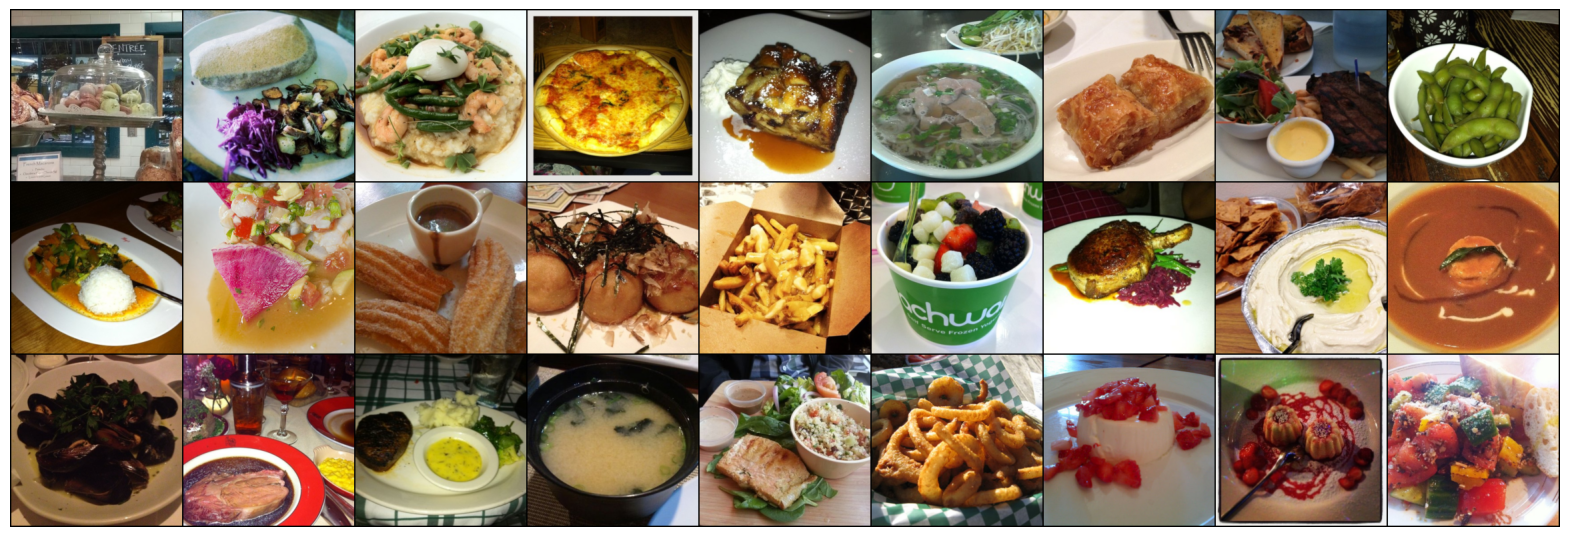

In [17]:
sample_inputs, _ = next(iter(loader_val))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)
plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

Next, we define ResNet-18:

In [ ]:
# define resnet building blocks

class ResidualBlock(nn.Module):
    def __init__(self, inchannel, outchannel, stride=1):

        super(ResidualBlock, self).__init__()

        self.left = nn.Sequential(nn.Conv2d(inchannel, outchannel, kernel_size=3,
                                         stride=stride, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel),
                                  nn.ReLU(inplace=True),
                                  nn.Conv2d(outchannel, outchannel, kernel_size=3,
                                         stride=1, padding=1, bias=False),
                                  nn.BatchNorm2d(outchannel))

        self.shortcut = nn.Sequential()

        if stride != 1 or inchannel != outchannel:

            self.shortcut = nn.Sequential(nn.Conv2d(inchannel, outchannel,
                                                 kernel_size=1, stride=stride,
                                                 padding = 0, bias=False),
                                          nn.BatchNorm2d(outchannel) )

    def forward(self, x):

        out = self.left(x)

        out += self.shortcut(x)

        out = F.relu(out)

        return out



# define resnet

class ResNet(nn.Module):

    def __init__(self, ResidualBlock, num_classes = 101):

        super(ResNet, self).__init__()

        self.inchannel = 16
        self.conv1 = nn.Sequential(nn.Conv2d(3, 16, kernel_size = 3, stride = 1,
                                            padding = 1, bias = False),
                                  nn.BatchNorm2d(16),
                                  nn.ReLU())

        self.layer1 = self.make_layer(ResidualBlock, 16, 2, stride = 2)
        self.layer2 = self.make_layer(ResidualBlock, 32, 2, stride = 2)
        self.layer3 = self.make_layer(ResidualBlock, 64, 2, stride = 2)
        self.layer4 = self.make_layer(ResidualBlock, 128, 2, stride = 2)
        self.layer5 = self.make_layer(ResidualBlock, 256, 2, stride = 2)
        self.layer6 = self.make_layer(ResidualBlock, 512, 2, stride = 2)
        self.maxpool = nn.MaxPool2d(4)
        self.fc = nn.Linear(512, num_classes)


    def make_layer(self, block, channels, num_blocks, stride):

        strides = [stride] + [1] * (num_blocks - 1)

        layers = []

        for stride in strides:

            layers.append(block(self.inchannel, channels, stride))

            self.inchannel = channels

        return nn.Sequential(*layers)


    def forward(self, x):

        x = self.conv1(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.maxpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

# please do not change the name of this class
def MyResNet():
    return ResNet(ResidualBlock)

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


def confusion(preds, y):
  with open(content_path+'/food-101/meta/labels.txt', 'r') as file:
        labels = [line.strip() for line in file if line.strip()]

  # Plotting the confusion matrix
  cm = confusion_matrix(y.cpu().numpy(), preds.cpu().numpy(), normalize='true', labels=range(len(labels)))
  fig, ax= plt.subplots(1, 1, figsize=(55,50))
  sns.heatmap(cm, annot=True, annot_kws={"size": 8}, ax=ax, cmap="Blues")

  # labels, title and ticks
  ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  ax.set_xticks(range(len(labels)), labels=labels); ax.set_yticks(range(len(labels)), labels=labels);
  ax.xaxis.set_ticklabels(labels, rotation = 90); ax.yaxis.set_ticklabels(labels, rotation=0);
  plt.show()

def incorrect_preds(preds, y, test_img):
  with open(content_path+'/food-101/meta/labels.txt', 'r') as file:
        labels = [line.strip() for line in file if line.strip()]
  # lets see a sample of the images which were classified incorrectly!
  correct = (preds == y).float()
  test_labels_check = correct.cpu().numpy()
  incorrect_indexes = np.where(test_labels_check == 0)

  test_img = test_img.cpu()
  samples = make_grid(denorm(test_img[incorrect_indexes][:9]), nrow=3,
                      padding=2, normalize=False, value_range=None,
                      scale_each=False, pad_value=0)
  plt.figure(figsize = (20,10))
  plt.title('Incorrectly Classified Instances')
  show(samples)
  labels = np.asarray(labels)
  print('Predicted label',labels[preds[incorrect_indexes].cpu().numpy()[:9]])
  print('True label', labels[y[incorrect_indexes].cpu().numpy()[:9]])
  print('Corresponding images are shown below')

In [ ]:
USE_GPU = True
dtype = torch.float32


if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:0')
else:
    device = torch.device('cpu')

print(device)


print_every = 10
def check_accuracy(loader, model, analysis=False, hotdog_data=False):
    # function for test accuracy on validation and test set

    num_correct = 0
    num_samples = 0
    target_class_correct = 0
    target_class_samples = 0
    target_class = 55 #hot dogs
    model.eval()  # set model to evaluation mode
    with torch.no_grad():
        for t, (x, y) in enumerate(loader):
            x = x.to(device=device, dtype=dtype)  # move to device
            if hotdog_data:
                y = torch.tensor(target_class).repeat(x.shape[0]).to(device=device, dtype=torch.long)
            else:
                y = y.to(device=device, dtype=torch.long)
            scores = model(x)
            _, preds = scores.max(1)
            num_correct += (preds == y).sum()
            num_samples += preds.size(0)
            mask = (y == target_class)  # Filter for target class
            if mask.sum() > 0:  # Ensure there are samples of the target class
                target_class_correct += (preds[mask] == y[mask]).sum()
                target_class_samples += mask.sum()

            if t == 0 and analysis:
              stack_labels = y
              stack_predicts = preds
            elif analysis:
              stack_labels = torch.cat([stack_labels, y], 0)
              stack_predicts = torch.cat([stack_predicts, preds], 0)
        acc = float(num_correct) / num_samples
        print('Got %d / %d correct of val set (%.2f)' % (num_correct, num_samples, 100 * acc))

        # Calculate accuracy for the target class
        if target_class_samples > 0:
            target_class_acc = float(target_class_correct) / target_class_samples
            print('Got %d / %d correct Hot Dogs (class %d) (%.2f%%)' % (
                target_class_correct, target_class_samples, target_class, 100 * target_class_acc))
        else:
            target_class_acc = 0.0
            print(f'No samples found for class {target_class}.')

        if analysis:
          print('check acc', type(stack_predicts), type(stack_labels))
          confusion(stack_predicts, stack_labels)
          incorrect_preds(preds, y, x)
        return float(acc)



def train_part(model, optimizer, epochs=1):
    """
    Train a model on food101 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model = model.to(device=device)  # move the model parameters to CPU/GPU
    for e in range(epochs):
        for t, (x, y) in enumerate(loader_train):
            model.train()  # put model to training mode
            x = x.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.long)

            scores = model(x)
            loss = F.cross_entropy(scores, y)

            # Zero out all of the gradients for the variables which the optimizer
            # will update.
            optimizer.zero_grad()

            loss.backward()

            # Update the parameters of the model using the gradients
            optimizer.step()

            if t % print_every == 0:
                print('Epoch: %d, Iteration %d, loss = %.4f' % (e, t, loss.item()))
        check_accuracy(loader_val, model)

In [ ]:
# define and train the network
model = MyResNet()
optimizer = optim.Adamax(model.parameters(), lr=0.0001, weight_decay=1e-7)

params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Total number of parameters is: {}".format(params))

train_part(model, optimizer, epochs = 10)


# report test set accuracy
check_accuracy(loader_val, model, analysis=True)


# save the model
torch.save(model.state_dict(), 'model.pt')

In [ ]:
# Load the saved weights into the model
model = MyResNet()
model.load_state_dict(torch.load('model.pt'))
model = model.to(device=device)  # move the model parameters to CPU/GPU

---

<!-- BEGIN QUESTION -->

### Network Performance

Run the code below when all engineering decisions have been made, do not overfit to the test set!

**Note that** this will appear in the output, and be checked by markers (so ensure it is present in the auto-export)

In [ ]:
# Run once your have trained your final model
check_accuracy(loader_test, model, analysis=True)

___

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.1: Engineering Decisions

Detail which engineering decisions you made to boost the performance of the baseline results. Note that you are not required to implement all of them and some in the list below are pointless. One or two reasonable choices are sufficient to reach all points, we are only looking for minor improvements. (12 points for improving performance, 22 points for the soundness of adaptations made)

### Select valid engineering decisions that were made to improve the baseline results for the custom deep learning model. Tick all that apply.

**Answer:**

- [x] 1. Data augmentation was used to increase the size and diversity of the training dataset.
- [ ] 2. Implemented a custom ResNet variant similar in depth to ResNet50.
- [x] 3. LeakyReLU activation was chosen to address the Dying ReLU problem.
- [ ] 4. Randomized search was used to tune hyperparameters, testing 20 combinations.
- [ ] 5. A k-fold cross-validation randomized search was used for hyperparameter tuning.
- [ ] 6. A cosine annealing learning rate scheduler was used to improve accuracy.
- [ ] 7. The best weight decay value was found to be <fill in>.
- [ ] 8. The optimal batch size for training was <fill in>.
- [ ] 9. Dropout was used extensively to improve regularization.
- [ ] 10. Batch normalization was used instead of dropout for regularization.
- [ ] 11. Early stopping was implemented to prevent overfitting.
- [ ] 12. The model achieved <fill in>% accuracy on the validation set after training for <fill in> epochs.
- [ ] 13. The learning rate was kept constant throughout training.
- [ ] 14. ImageNet AutoAugment was used for data augmentation.
- [ ] 15. Data augmentation transformations were manually defined.
- [ ] 16. The final model architecture included max pooling layers after each convolutional block.
- [ ] 17. Global average pooling was used in the final layer instead of max pooling.
- [ ] 18. The training dataset was expanded to include 200 additional classes.
- [ ] 19. Increasing the number of epochs improved model accuracy without overfitting.
- [ ] 20. The model achieved a plateau in validation accuracy, indicating overfitting.
- [ ] 21. The labels were converted to binary classification (Hot Dog/No Hot Dog) to improve only Hot Dog detection accuracy.


New accuracy after extension: ...

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q2.2: Out of distribution evaluation

Lets see how your trained model performs on a custom hot dog detection dataset. Do not try and modify your model to perform well on this task, this is just a reflective exercise. How did your model perform at the task? Why do you think this was the case? Detail one method which you expect would improve model performance. (5 points)

In [ ]:
from icl_dl_cw2_utils.utils.hotdogdataset import DLHotDogDataset
from torch.utils.data import DataLoader, sampler
image_size_ = 256
batch_size = 128

mean = torch.Tensor([0.485, 0.456, 0.406]) # assuming same dist as imagenet
std = torch.Tensor([0.229, 0.224, 0.225])

transform = transforms.Compose(
        [
            transforms.Resize(256),
            transforms.CenterCrop(256),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist()),
        ]

    )

synth_hotdog_dataset = DLHotDogDataset(root=content_path, transform=transform, split='test', preload=True)

print(len(synth_hotdog_dataset))

synth_hotdog_loader = DataLoader(synth_hotdog_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers)

In [ ]:
sample_inputs, _ = next(iter(synth_hotdog_loader))
fixed_input = sample_inputs[:27, :, :, :]

img = make_grid(denorm(fixed_input), nrow=9, padding=2, normalize=False,
                value_range=None, scale_each=False, pad_value=0)

plt.figure(figsize=(20,10))
plt.axis('off')
show(img)

In [ ]:
check_accuracy(synth_hotdog_loader, model, analysis=True, hotdog_data=True)

**Answer:**

ANSWER HERE

<!-- END QUESTION -->

## Part 3 (11 points)

The code provided below will allow you to visualise the feature maps computed by different layers of your network. Run the code (install matplotlib if necessary) and *answer the following questions*:

<!-- BEGIN QUESTION -->

### Q3.1 : Learned Features

Compare the feature maps from low-level layers to high-level layers, what do you observe? (5 points)

**Feature Visualization**

The code below will visualize the features of your network layers (you may need to modify the layer names if you made changes to your architecture).

If you change the plotting code, please ensure it still exports correctly when running the submission cell.

In [ ]:
import matplotlib.pyplot as plt

def plot_model_features():
    fig = plt.tight_layout()
    activation = {}
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook
    vis_labels = ['conv1', 'layer1', 'layer2', 'layer3', 'layer4', 'layer5', 'layer6']

    for l in vis_labels:
        getattr(model, l).register_forward_hook(get_activation(l))


    data, _ = test_dataset[999]
    data = data.unsqueeze_(0).to(device = device, dtype = dtype)
    output = model(data)

    for idx, l in enumerate(vis_labels):
        act = activation[l].squeeze()

        # only showing the first 16 channels
        ncols, nrows = 8, 2

        fig, axarr = plt.subplots(nrows, ncols, figsize=(15,5))
        fig.suptitle(l)

        count = 0
        for i in range(nrows):
            for j in range(ncols):
                axarr[i, j].imshow(act[count].cpu())
                axarr[i, j].axis('off')
                count += 1

In [ ]:
# Visualize the figure here, so it is exported nicely
plot_model_features()

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Q3.2: Performance Analysis

Use the training log, reported test set accuracy and the feature maps, analyse the performance of your network. If you think the performance is sufficiently good, explain why; if not, what might be the problem and how can you improve the performance? (6 points)

**Answer:**

ANSWER HERE

---

<!-- END QUESTION -->

## Submission
Git push your finalized version of this notebook (with saved outputs) to the gitlab repo which you were assigned. You should request our tests once and check that the ```preview.pdf```:
* Passes all public tests (these are the same ones provided / embedded in the notebook itself)
* Contains your qualitative answers
* Contains your figures (confusion matrix and network features)

You do not need to include OTTER_LOG in the submitted files, as we will run all the tests from scratch on the LabTS.

---

To double-check your work, the cell below will rerun all of the autograder tests.

In [ ]:
grader.check_all()